# <a href="https://miptstats.github.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 5. Компьютерное зрение & генеративные модели


**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds24_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*


**Баллы за задание:**

* Задача 1 &mdash; 150 баллов
* Задача 2 &mdash; 40 баллов

Баллы учитываются в <b><font color="green">факультативной части</font></b> курса и не влияют на оценку по основной части.

In [1]:
# Bot check

# HW_ID: fpmi_ad5
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [2]:
!pip install torchinfo

In [2]:
import time
import warnings
from collections import defaultdict
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchinfo import summary

from IPython.display import clear_output
sns.set(font_scale=1, style='darkgrid', palette='Set2')
warnings.simplefilter("ignore")

device = f"cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


Перед выполнением задания обязательно посмотрите <a href="https://miptstats.github.io/courses/ad_fivt/lecture5_1.pdf" target="_blank">презентацию</a> и <a href="https://miptstats.github.io/courses/ad_fivt/CV_classification.html" target="_blank">ноутбук</a> про сверточные сети и классификацию, а так же <a href="https://miptstats.github.io/courses/ad_fivt/lecture5_2.pdf" target="_blank">презентацию</a> и <a href="https://miptstats.github.io/courses/ad_fivt/CV_complex_examples.html" target="_blank">ноутбук</a> про перенос стиля и генеративные сети.

---
### Задача 1. Классификация MNIST


Цель: сравнить сверточные нейросети с разными параметрами на датасете рукописных цифр MNIST. В нем содержатся черно-белые изображения цифр, всего 10 классов для каждой цифры. Пользоваться кодом семинара можно без ограничений. Классификация MNIST намного легче, чем CIFAR, поэтому ваша задача хотя бы в одной из моделей получить 98% точности **на валидации**.

> Использования слоев с семинара (свертка, pooling) более чем достаточно для достижения 98% точности на тесте. Также не делайте сеть глубокой.

> Тестируйте работоспособность кода на CPU с небольшим кол-вом итераций. Если все работает, и хочется ускорить процесс, переходите на GPU.

Следуйте указаниям ниже.

Загрузим датаcет из `torchvision.datasets`.

In [3]:
# Данные для обучения
train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                           download=True,
                                           transform=transforms.ToTensor())
# Данные для тестирования
val_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                         download=True,
                                         transform=transforms.ToTensor())
# Классы объектов в датасете
classes = [str(i) for i in range(10)]

Визуализируйте несколько картинок с соответствующими метками из датасета.

Создадим функцию для визуализации картинки.

In [4]:
def DrawPic(df, idx, df_name, value):
    plt.imshow(df[idx][0].permute(1, 2, 0))
    plt.title(f"{df_name}: {value[df[idx][1]]}")
    plt.axis("off")

Размер картинки:torch.Size([1, 28, 28])


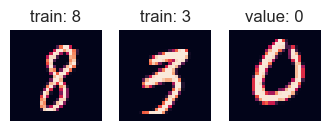

In [5]:
# берем 2 рандомных индекса
train_idx1_visual, train_idx2_visual, val_idx_visual = np.random.randint(0, 10000, 3)
print(f"Размер картинки:{train_dataset[0][0].shape}")

plt.figure(figsize=(4, 2))
plt.subplot(131)
DrawPic(train_dataset, train_idx1_visual, "train", classes)

plt.subplot(132)
DrawPic(train_dataset, train_idx2_visual, "train", classes)

plt.subplot(133)
DrawPic(val_dataset, val_idx_visual, "value", classes)

Создайте генераторы батчей.

In [7]:
# Количество элементов в батче
batch_size = 32

train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

**Эксперимент 1.** Создайте хотя бы 5 сверточных нейросетей с разным количеством линейных и сверточных слоев. Должен присутствовать хотя бы 1 сверточный слой и хотя бы 1 линейный слой. Для каждой посмотрите количество параметров с помощью `torchinfo.summary`.

In [ ]:
# Модель с 1 свёрточным слоем и 1 линейным
model_cnn_1_1 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=5408, out_features=10),
).to(device)

summary(model_cnn_1_1, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─MaxPool2d: 1-2                         [1, 32, 13, 13]           --
├─ReLU: 1-3                              [1, 32, 13, 13]           --
├─Flatten: 1-4                           [1, 5408]                 --
├─Linear: 1-5                            [1, 10]                   54,090
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
Total mult-adds (M): 0.27
Input size (MB): 0.00
Forward/backward pass size (MB): 0.17
Params size (MB): 0.22
Estimated Total Size (MB): 0.39

In [ ]:
# Модель с 2 свёрточными слоями и 1 линейным
model_cnn_2_1 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1600, out_features=10),
).to(device)

summary(model_cnn_2_1, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─MaxPool2d: 1-2                         [1, 32, 13, 13]           --
├─ReLU: 1-3                              [1, 32, 13, 13]           --
├─Conv2d: 1-4                            [1, 64, 11, 11]           18,496
├─MaxPool2d: 1-5                         [1, 64, 5, 5]             --
├─ReLU: 1-6                              [1, 64, 5, 5]             --
├─Flatten: 1-7                           [1, 1600]                 --
├─Linear: 1-8                            [1, 10]                   16,010
Total params: 34,826
Trainable params: 34,826
Non-trainable params: 0
Total mult-adds (M): 2.47
Input size (MB): 0.00
Forward/backward pass size (MB): 0.24
Params size (MB): 0.14
Estimated Total Size (MB): 0.38

In [ ]:
# Модель с 2 свёрточными слоями и 2 линейными
model_cnn_2_2 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1600, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

summary(model_cnn_2_2, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─MaxPool2d: 1-2                         [1, 32, 13, 13]           --
├─ReLU: 1-3                              [1, 32, 13, 13]           --
├─Conv2d: 1-4                            [1, 64, 11, 11]           18,496
├─MaxPool2d: 1-5                         [1, 64, 5, 5]             --
├─ReLU: 1-6                              [1, 64, 5, 5]             --
├─Flatten: 1-7                           [1, 1600]                 --
├─Linear: 1-8                            [1, 256]                  409,856
├─ReLU: 1-9                              [1, 256]                  --
├─Linear: 1-10                           [1, 10]                   2,570
Total params: 431,242
Trainable params: 431,242
Non-trainable params: 0
Total mult-adds (M): 2.87
Input size (MB): 0.00
Forward/backward pass 

In [ ]:
# Модель с 3 свёрточными слоями и 1 линейными
model_cnn_3_1 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

summary(model_cnn_3_1, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─MaxPool2d: 1-2                         [1, 32, 13, 13]           --
├─ReLU: 1-3                              [1, 32, 13, 13]           --
├─Conv2d: 1-4                            [1, 64, 11, 11]           18,496
├─MaxPool2d: 1-5                         [1, 64, 5, 5]             --
├─ReLU: 1-6                              [1, 64, 5, 5]             --
├─Conv2d: 1-7                            [1, 256, 3, 3]            147,712
├─MaxPool2d: 1-8                         [1, 256, 1, 1]            --
├─ReLU: 1-9                              [1, 256, 1, 1]            --
├─Flatten: 1-10                          [1, 256]                  --
├─Linear: 1-11                           [1, 10]                   2,570
Total params: 169,098
Trainable params: 169,098
Non-trainable params: 0


In [ ]:
# Модель с 3 свёрточными слоями и 2 линейными
model_cnn_3_2 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=256, out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=10),
).to(device)

summary(model_cnn_3_2, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─MaxPool2d: 1-2                         [1, 32, 13, 13]           --
├─ReLU: 1-3                              [1, 32, 13, 13]           --
├─Conv2d: 1-4                            [1, 128, 11, 11]          36,992
├─MaxPool2d: 1-5                         [1, 128, 5, 5]            --
├─ReLU: 1-6                              [1, 128, 5, 5]            --
├─Conv2d: 1-7                            [1, 256, 3, 3]            295,168
├─MaxPool2d: 1-8                         [1, 256, 1, 1]            --
├─ReLU: 1-9                              [1, 256, 1, 1]            --
├─Flatten: 1-10                          [1, 256]                  --
├─Linear: 1-11                           [1, 64]                   16,448
├─ReLU: 1-12                             [1, 64]                   --
├

Обучите сети, используя функцию потерь `nn.CrossEntropyLoss` и оптимизатор `torch.optim.Adam` с дефолтными параметрами.

Создадим функции для обучения моделей, сохранения процесса обучения и визуализации.

In [10]:
def print_epoch(epoch, num_epochs, history, t):
    """
    Функция для вывода информации про эпоху.
    :param epoch: номер эпохи
    :param num_epochs: общее количество эпох
    :param history: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    :param t: время эпохи в секундах
    """
    clear_output(wait=True)
    print("Epoch {} of {} took {:.3f} s".format(epoch + 1, num_epochs, t))
    print("  training loss: \t{:.6f}".format(history["loss"]["train"][-1]))
    print("  validation loss: \t{:.6f}".format(history["loss"]["val"][-1]))
    print(
        "  training accuracy: \t\t\t{:.2f} %".format(
            history["acc"]["train"][-1] * 100
        )
    )
    print(
        "  validation accuracy: \t\t\t{:.2f} %".format(
            history["acc"]["val"][-1] * 100
        )
    )


def update_history(history, loss, acc, num_batches, mode):
    """
    Функция для сохранения лосса и точности в историю.
    :param history: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    :param loss: сумма лосса за весь батч
    :param acc: сумма точности за весь батч
    :param num_batches: общее количество батчей
    :param mode: train или val
    """
    # Подсчитываем лоссы и сохраняем в "историю"
    loss /= num_batches
    acc /= num_batches
    history["loss"][mode].append(loss)
    history["acc"][mode].append(acc)


def get_batch_loss(
        X_batch, y_batch, model, criterion, current_loss, current_acc
):
    """
    Функция для подсчета лосса (без backward pass).
    :param X_batch: батч картиок X
    :param y_batch: батч меток y
    :param model: модель для получения логитов
    :param criterion: функция потерь
    :param current_loss: текущий суммарный лосс за батч
    :param current_acc: текущая суммарная точность за батч
    :return: лосс на данном батче; current_loss; current_acc
    """

    # Обучаемся на батче (одна "итерация" обучения нейросети)
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    # Логиты на выходе модели
    logits = model(X_batch)

    # Подсчитываем лосс
    loss = criterion(logits, y_batch.long().to(device))

    # Сохраняем лоссы и точность на трейне
    current_loss += loss.detach().cpu().numpy()
    y_pred = logits.max(1)[1].detach().cpu().numpy()
    current_acc += np.mean(y_batch.cpu().numpy() == y_pred)
    return loss, current_loss, current_acc


def train(
        model, criterion, optimizer, train_batch_gen, val_batch_gen, num_epochs=40
):
    """
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    """

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss, val_loss = 0, 0
        train_acc, val_acc = 0, 0
        start_time = time.time()

        # ----------------------   ОБУЧЕНИЕ   ----------------------#
        model.train(True)
        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # Считаем лосс, обновляем train_loss, train_acc
            loss, train_loss, train_acc = get_batch_loss(
                X_batch, y_batch, model, criterion, train_loss, train_acc
            )

            # Обратный проход
            loss.backward()
            # Шаг градиента
            optimizer.step()
            # Зануляем градиенты
            optimizer.zero_grad()

        # Подсчитываем лоссы и сохраняем в "историю"
        update_history(
            history, train_loss, train_acc, len(train_batch_gen), "train"
        )

        # ----------------------   ВАЛИДАЦИЯ   ----------------------#
        model.train(False)
        # Контекстный менеджер, отключающий подсчет градиентов
        with torch.no_grad():
            # Полный проход по валидационному датасету
            for X_batch, y_batch in val_batch_gen:
                # Считаем лосс, обновляем val_loss, val_acc
                _, val_loss, val_acc = get_batch_loss(
                    X_batch, y_batch, model, criterion, val_loss, val_acc
                )

        # Подсчитываем лоссы и сохраняем в "историю"
        update_history(history, val_loss, val_acc, len(val_batch_gen), "val")

        # Печатаем результаты после каждой эпохи
        print_epoch(epoch, num_epochs, history, time.time() - start_time)

    return history

In [11]:
def plot_histories(histories, names, main_size=2, other_size=1.5):
    """
    Функция для визуализации лосса и метрики по нескольким историям.
    :param history: (list) список историй моделей
    :param names: (list) список названий моделей
    """
    sns.set_style("darkgrid")
    colors = ["darkblue", "lightcoral", "limegreen",
              "sandybrown", "darkslategray"]
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    epochs = np.min([len(h["loss"]["train"]) for h in histories])
    for i, (history, name) in enumerate(zip(histories, names)):
        axs[0].set_title("Лосс")
        axs[0].plot(
            history["loss"]["train"][:epochs],
            label=f"{name}",
            lw=main_size,
            c=colors[i],
        )
        axs[0].plot(
            history["loss"]["val"][:epochs], lw=other_size, c=colors[i], ls="--"
        )
        axs[0].set_xlabel("Эпохи")

        axs[1].set_title("Точность")
        axs[1].plot(
            history["acc"]["train"][:epochs], label=f"{name}", lw=main_size, c=colors[i]
        )
        axs[1].plot(
            history["acc"]["val"][:epochs], lw=other_size, c=colors[i], ls="--"
        )
        axs[1].set_xlabel("Эпохи")
        axs[1].legend()

    dummy_lines = [
        axs[0].plot([], [], c="black", lw=main_size)[0],
        axs[0].plot([], [], c="black", lw=other_size, ls="--")[0],
    ]
    for i in range(2):
        legend = axs[i].legend(loc=3 - i)
        axs[i].legend(dummy_lines, ["train", "val"], loc=4)
        axs[i].add_artist(legend)
    plt.show()

Теперь мы готовы обучать модели, только нужно задать функцию потерь и оптимизаторы.

In [ ]:
criterion = nn.CrossEntropyLoss()

models_experiment1 = [model_cnn_1_1, model_cnn_2_1, model_cnn_2_2, model_cnn_3_1, model_cnn_3_2]
optimizer_experiment1 = [torch.optim.Adam(model.parameters()) for model in models_experiment1]

In [ ]:
# Будем сохранять историю обучения моделей
history_experiment1 = []

# Название моделей
exper1_models_name = ["cnn_1_1", "cnn_2_1", "cnn_2_2",
                           "cnn_3_1", "cnn_3_2"]

# Само обучение
for model_num in range(len(models_experiment1)):
    history_experiment1.append(
        train(
            models_experiment1[model_num],
            criterion,
            optimizer_experiment1[model_num],
            train_batch_gen,
            val_batch_gen,
            num_epochs=4
        )
    )
    torch.save(models_experiment1[model_num].state_dict(),
               f"{exper1_models_name[model_num]}.pth")

Epoch 4 of 4 took 13.710 s
  training loss: 	0.038700
  validation loss: 	0.048969
  training accuracy: 			98.80 %
  validation accuracy: 			98.58 %


Постройте график лосса и график accuracy, где сравниваются все модели (на train и на val). Нужная функция есть в семинаре.

Вначале выведем все графики обучения моделей на одном полотне.

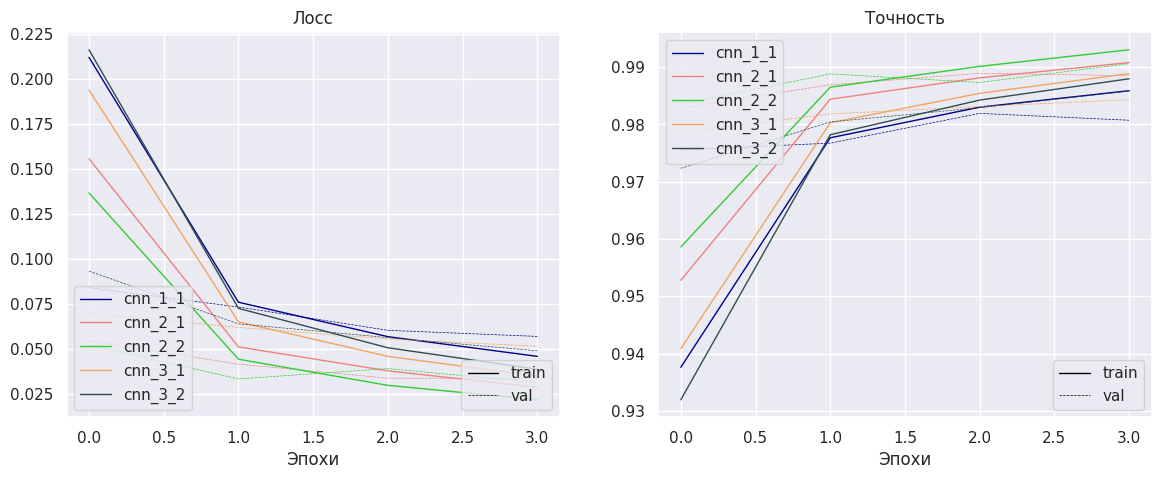

In [ ]:
plot_histories(history_experiment1, exper1_models_name, 1, 0.5)

Довольно трудно воспринимать все графики на одном полотне, потому что графики ведут себя примерно одинакого и значения также близки, поэтому разделим из по признакам: число сверточных и линецных слоев и выведем.

Сравним вначале графики при одинаковом числе свёрточных слоёв

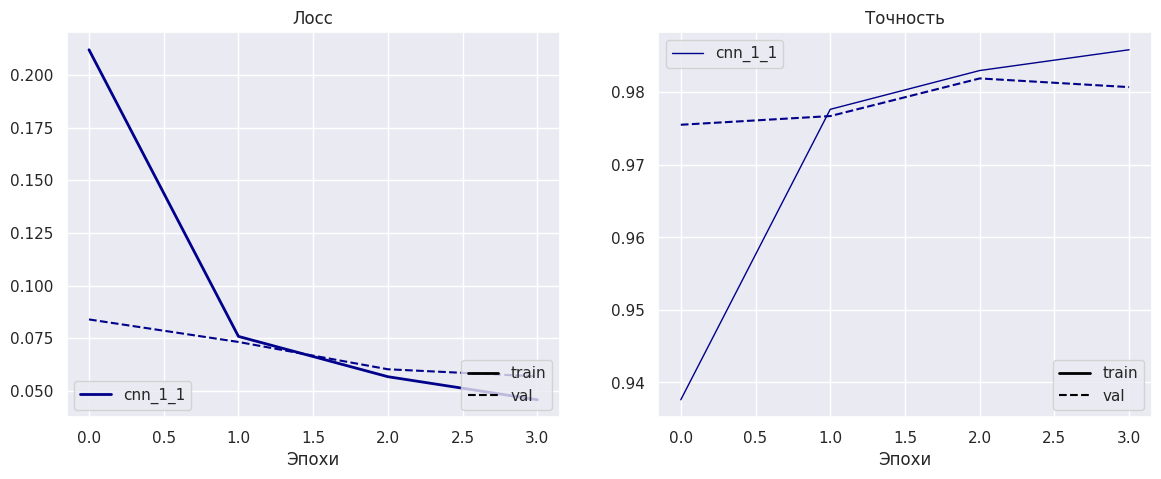

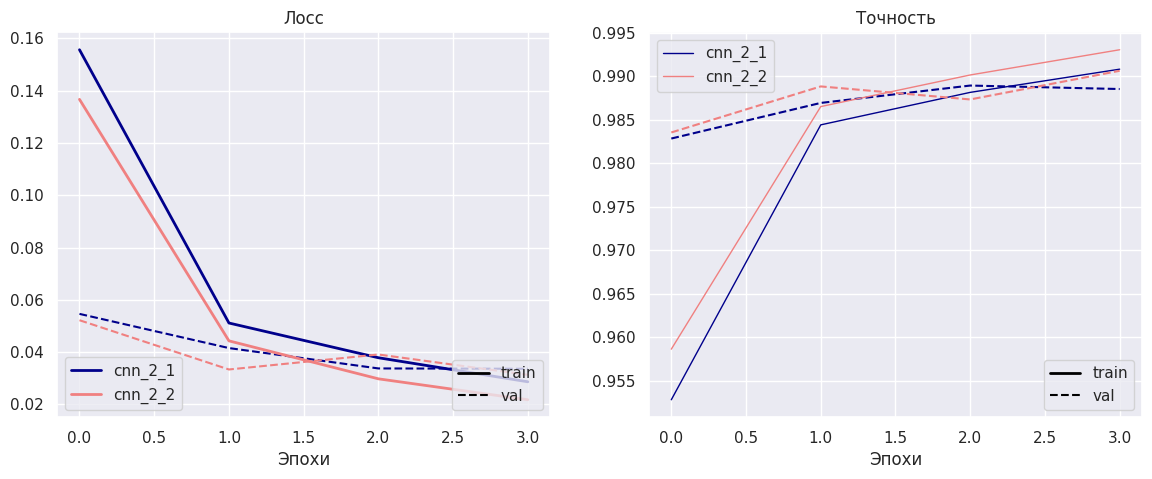

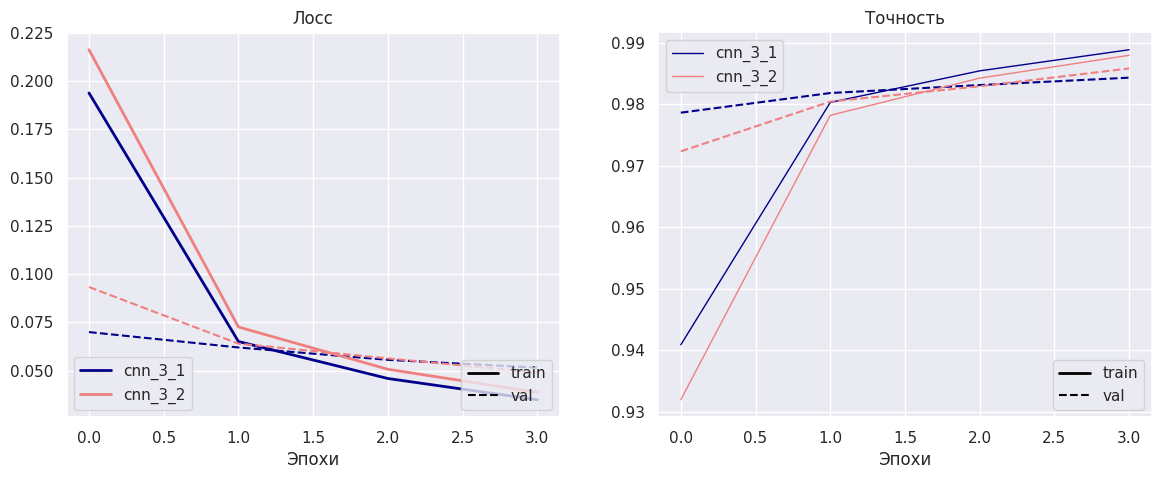

In [ ]:
# Один сверточный слой
plot_histories(history_experiment1[:1], exper1_models_name[:1])

# Два сверточных слоя
plot_histories(history_experiment1[1:3], exper1_models_name[1:3])

# Три сверточных слоя
plot_histories(history_experiment1[3:], exper1_models_name[3:])

Теперь выведем графики по числу линейных слоев.

На трех сверточных слоях итоговая точность выше у модели с одним линейным слоем, но эта разница со верменым уменьшается, при этом результаты на валидационном наборе данных практически не отличается.

При двух сверточных слоях, ситуация противоположная,тренировочная модель с большим числом сверточных слоев показывает себя лучше, чем с меньшим, причем разница между ними не уменьшается. На валидационном наборе данных разница колеблется.


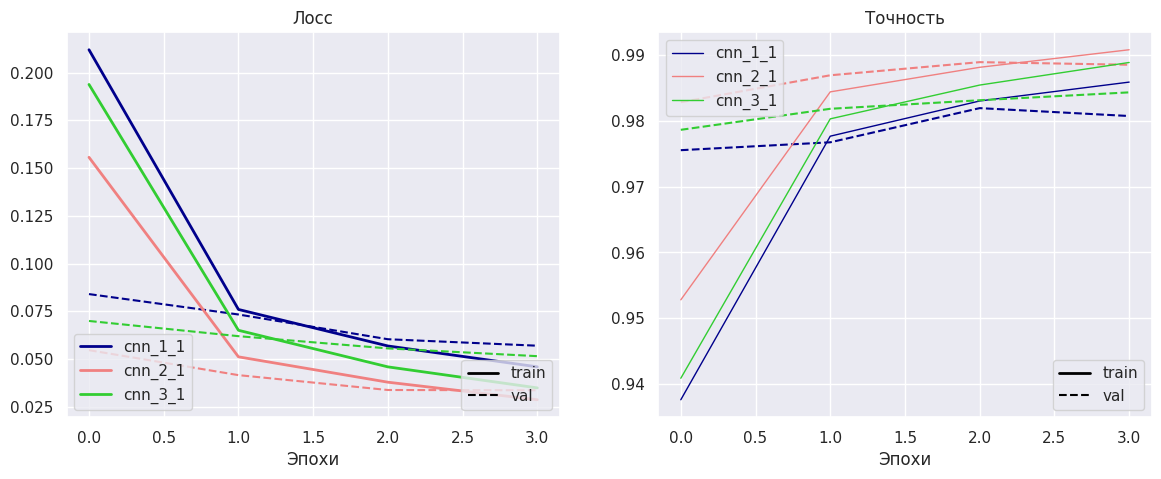

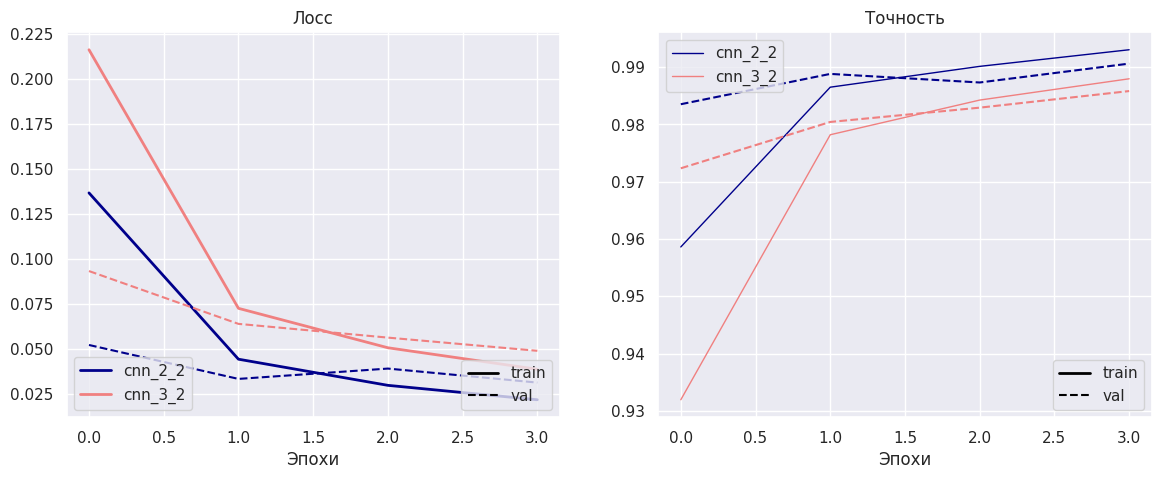

In [ ]:
# Один линейный слой
plot_histories([history_experiment1[ind] for ind in [0, 1, 3]],
               [exper1_models_name[ind] for ind in [0, 1, 3]])

# Два линейных слоя
plot_histories([history_experiment1[ind] for ind in [2, 4]],
               [exper1_models_name[ind] for ind in [2, 4]])

Эти графики более наглядные, так как по первому четко видно, что лучше всего модель с двумя сверточными слоями, а хуже всего себя показала модель с одним.

На обоих графиказ видно, что модель с тремя сверточными слоями показвает себя хуже, чем с тремя.

Сделайте вывод. Как количество разных слоев влияет на качество и время обучения?

**Вывод по эксперименту 1:** По выбранным пяти моделям можно сделать следующие выводы:
1. большее или меньшее число сверточных или линейных слоев не гарантируют большую точность
2. Тоже относится и к числу переменных в модели: число переменныз у cnn_3_2 в два раза выше, чем у cnn_3_1, но результаты cnn_3_1 выше. С лругой стороны обратная ситуация наблюдаетсяу cnn_2_1 и cnn_2_2, у последнего число переменных наибольшее, также и результат выше.
3. Лучше всего себя показала модель cnn_2_2.

**Эксперимент 2.** Теперь выберите лучший вариант, зафиксируйте это количество сверточных и линейных слоев и обучите хотя бы 4 сверточных нейросети, варьируя размеры ядер сверток. Например, в разном порядке поставьте ядра 3x3, 5x5.

В ходе предыдущего эксперимента выяснили, что лучше всего ведет себя cnn_2_2: модель с двумя свёрточными слоями и с двумя линейными, поэтому построим четырем модели варьирую число ядер: 2x2, 4x4, 6x6, 8x8.

In [15]:
# Размер ядра 2х2
cnn_2 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=2),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=2304, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

summary(cnn_2, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 27, 27]           160
├─MaxPool2d: 1-2                         [1, 32, 13, 13]           --
├─ReLU: 1-3                              [1, 32, 13, 13]           --
├─Conv2d: 1-4                            [1, 64, 12, 12]           8,256
├─MaxPool2d: 1-5                         [1, 64, 6, 6]             --
├─ReLU: 1-6                              [1, 64, 6, 6]             --
├─Flatten: 1-7                           [1, 2304]                 --
├─Linear: 1-8                            [1, 256]                  590,080
├─ReLU: 1-9                              [1, 256]                  --
├─Linear: 1-10                           [1, 10]                   2,570
Total params: 601,066
Trainable params: 601,066
Non-trainable params: 0
Total mult-adds (M): 1.90
Input size (MB): 0.00
Forward/backward pass s

In [16]:
# Размер ядра 4х4
cnn_4 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1024, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

summary(cnn_4, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 25, 25]           544
├─MaxPool2d: 1-2                         [1, 32, 12, 12]           --
├─ReLU: 1-3                              [1, 32, 12, 12]           --
├─Conv2d: 1-4                            [1, 64, 9, 9]             32,832
├─MaxPool2d: 1-5                         [1, 64, 4, 4]             --
├─ReLU: 1-6                              [1, 64, 4, 4]             --
├─Flatten: 1-7                           [1, 1024]                 --
├─Linear: 1-8                            [1, 256]                  262,400
├─ReLU: 1-9                              [1, 256]                  --
├─Linear: 1-10                           [1, 10]                   2,570
Total params: 298,346
Trainable params: 298,346
Non-trainable params: 0
Total mult-adds (M): 3.26
Input size (MB): 0.00
Forward/backward pass 

In [17]:
# Размер ядра 6x6
cnn_6 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=6),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=6),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=576, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

summary(cnn_6, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 23, 23]           1,184
├─MaxPool2d: 1-2                         [1, 32, 11, 11]           --
├─ReLU: 1-3                              [1, 32, 11, 11]           --
├─Conv2d: 1-4                            [1, 64, 6, 6]             73,792
├─MaxPool2d: 1-5                         [1, 64, 3, 3]             --
├─ReLU: 1-6                              [1, 64, 3, 3]             --
├─Flatten: 1-7                           [1, 576]                  --
├─Linear: 1-8                            [1, 256]                  147,712
├─ReLU: 1-9                              [1, 256]                  --
├─Linear: 1-10                           [1, 10]                   2,570
Total params: 225,258
Trainable params: 225,258
Non-trainable params: 0
Total mult-adds (M): 3.43
Input size (MB): 0.00
Forward/backward pas

In [18]:
# Размер ядра 8x8
cnn_8 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=8),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=8),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=64, out_features=32),
    nn.ReLU(),
    nn.Linear(in_features=32, out_features=10),
).to(device)

summary(cnn_8, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 21, 21]           2,080
├─MaxPool2d: 1-2                         [1, 32, 10, 10]           --
├─ReLU: 1-3                              [1, 32, 10, 10]           --
├─Conv2d: 1-4                            [1, 64, 3, 3]             131,136
├─MaxPool2d: 1-5                         [1, 64, 1, 1]             --
├─ReLU: 1-6                              [1, 64, 1, 1]             --
├─Flatten: 1-7                           [1, 64]                   --
├─Linear: 1-8                            [1, 32]                   2,080
├─ReLU: 1-9                              [1, 32]                   --
├─Linear: 1-10                           [1, 10]                   330
Total params: 135,626
Trainable params: 135,626
Non-trainable params: 0
Total mult-adds (M): 2.10
Input size (MB): 0.00
Forward/backward pass s

Теперь обучим модели, но вначале, как и в эксперимнте 1 необзодимо подготовить данные, оптимизаторы, функция потери, имена файлов.

In [19]:
criterion = nn.CrossEntropyLoss()

# массив моделей и оптимизаторов
models_experiment2 = [cnn_2, cnn_4, cnn_6, cnn_8]
optimizer_experiment2 = [torch.optim.Adam(model.parameters()) for model in models_experiment2]

# массив для сохранения историй обучения
history_experiment2 = []

# Название моделей
exper2_models_name = ["cnn_2", "cnn_4", "cnn_6", "cnn_8"]

Для наглядности времени обучения, будем обучать модели в разных явейках.

In [20]:
def train_kernal_size(id):
    history_experiment2.append(
        train(
            models_experiment2[id],
            criterion,
            optimizer_experiment2[id],
            train_batch_gen,
            val_batch_gen,
            num_epochs=4
        )
    )
    torch.save(models_experiment2[id].state_dict(),
               f"{exper2_models_name[id]}.pth")

In [56]:
# Обучение модели 2х2
train_kernal_size(0)

Epoch 4 of 4 took 11.832 s
  training loss: 	0.025597
  validation loss: 	0.037937
  training accuracy: 			99.18 %
  validation accuracy: 			98.82 %


In [21]:
# Обучение модели 4х4
train_kernal_size(1)

Epoch 4 of 4 took 13.749 s
  training loss: 	0.021231
  validation loss: 	0.026596
  training accuracy: 			99.32 %
  validation accuracy: 			99.15 %


In [58]:
# Обучение модели 6х6
train_kernal_size(2)

Epoch 4 of 4 took 12.267 s
  training loss: 	0.023322
  validation loss: 	0.041057
  training accuracy: 			99.26 %
  validation accuracy: 			98.76 %


In [59]:
# Обучение модели 8х8
train_kernal_size(3)

Epoch 4 of 4 took 11.975 s
  training loss: 	0.036621
  validation loss: 	0.046614
  training accuracy: 			98.84 %
  validation accuracy: 			98.46 %


Постройте график лосса и график accuracy, где сравниваются все модели этого эксперимента (на train и на val).

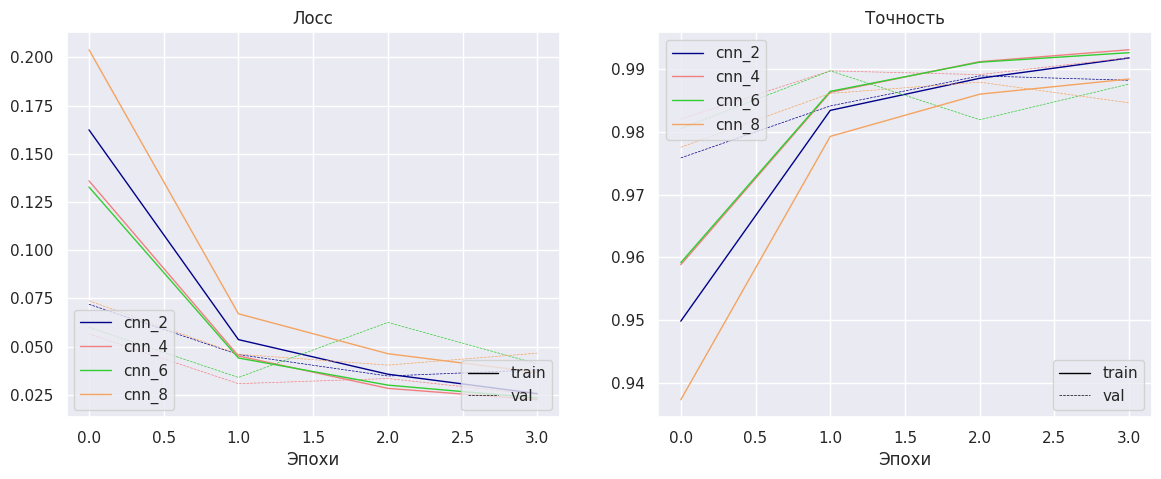

In [60]:
plot_histories(history_experiment2, exper2_models_name, 1, 0.5)

Сделайте вывод. Как размеры ядер влияют на качество и время обучения?

**Вывод по эксперименту 2:** Лучше всего себя показывают модели cnn_4 и cnn_6, а с cnn_2 и cnn_8 хуже. При этом на тренировочной модели точность моделей cnn_4 и cnn_6 примерно одинаковая, но cnn_4 показывает себя лучше и более стабильна на валидационных данных, чем cnn_6.

При этом время обучения моделей примерно, одинаковая, то есть, исходя из результатов эксперимента, можно сказать, что время обучения не сильно зависит от размера ядер, хотя чило переменных в cnn_8 более чем в 4 раза превосходит таковой в cnn_2.

**Анализ лучшей модели.** Выберите лучшую конфигурацию из всех по accuracy на валидации. Она должна быть не меньше 98%.

Наивысшая валидация у cnn_4, поэтому мы будем использовать ее.

In [22]:
best_model = cnn_4

Проведите еще один проход валидации выбранной моделью по всему датасету. В нем посчитайте точность по каждому классу и соберите информацию о неправильных предсказаниях. Равномерна ли точность по отношению к классам? Покажите 10-20 примеров, на которых нейросеть выдала неправильную метку. Что можно о них сказать?

Будем проходиться по валидационному набору данных с помощью батчей размера 1. Сохраняя точность по каждому классу и сохряняя индексы ошибок.

In [41]:
# Генератор батчей размера 1
val_best_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=1, shuffle=False
)

# Классы для подсчета точности по разным цифрам
classes_correct = [0] * 10
classes_all = [0] * 10

# Сохраняем массив ошибок
mistakes = []

In [42]:
best_model.train(False)
# Контекстный менеджер, отключающий подсчет градиентов
with torch.no_grad():
    # Полный проход по валидационному датасету
    for X_batch, y_batch in val_best_gen:
        val_loss, val_acc = 0, 0
        # Считаем лосс, обновляем val_loss, val_acc
        _, val_loss, val_acc = get_batch_loss(
            X_batch, y_batch, best_model, criterion, val_loss, val_acc
        )
        # Так как размеры батчей 1, то val_acc = 0/1
        classes_all[int(y_batch[0])] += 1
        if (val_acc > 0.5):
            classes_correct[int(y_batch[0])] += 1
        else:
            mistakes.append([X_batch, y_batch, best_model(X_batch)])

# Найдем точность
classes_acc = [0] * 10
for num in range(len(classes_all)):
    classes_acc[num] = classes_correct[num] / classes_all[num]

In [44]:
print(f'Количество ошибок на валидации: {len(mistakes)}')
print()

# Выведем точность по каждому из классов
for num in range(len(classes_acc)):
  print(f'Точность по классу {num}: {np.round(classes_acc[num], 3)}')

Количество ошибок на валидации: 85

Точность по классу 0: 0.986
Точность по классу 1: 0.996
Точность по классу 2: 0.996
Точность по классу 3: 0.998
Точность по классу 4: 0.991
Точность по классу 5: 0.987
Точность по классу 6: 0.99
Точность по классу 7: 0.988
Точность по классу 8: 0.993
Точность по классу 9: 0.99


Выведем первые 15 ошибок.

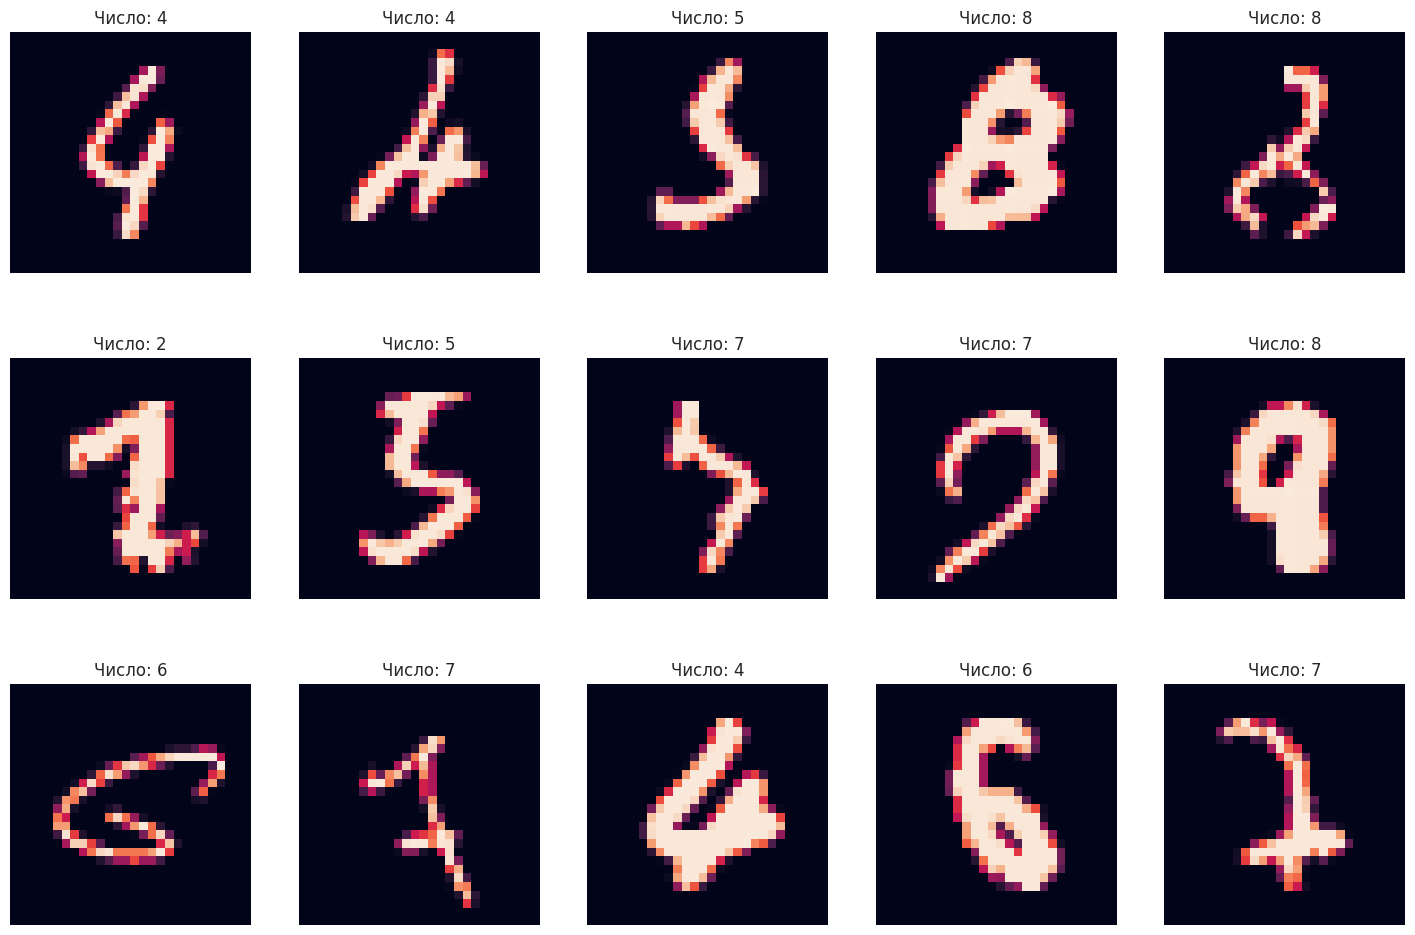

In [63]:
rows, cols = 3, 5
fig, axs = plt.subplots(rows, cols, figsize=(18, 12))
num = 0;

for mistake_im, mistake_class, predict in mistakes:
    axs[num // cols, num % cols].imshow(mistake_im[0].permute(1, 2, 0))
    axs[num // cols, num % cols].set_title(f"Число: {mistake_class[0]}")
    axs[num // cols, num % cols].axis("off")
    # plt.subplot(100 + 10*(1 + num // cols) + 1 + num % cols)
    # plt.imshow(mistake_im[0].permute(1, 2, 0))
    # plt.title(f"Число: {mistake_class}")
    # plt.axis("off")
    num += 1
    if (num >= 15):
      break
# mistakes[0][0][0]

**Ответ:** Существует зависимость точности распознавания от класса, к примеру цифры 1, 2, 3 модель распознает с точностью выше 99.5%, а 0 и 7 с точностью ниже 99%. То есть некоторые цифры модель легче распознает, а в каких-то чаще путается.
Также среди изображенных ошибок большинство тех, в которых может запутаться и человек. 


**Вывод по всей задаче:** В ходе двух экспериментов построили модель для распознования чисел, при этом модель строилась экспериментально, то есть рассматривались некоторые варианты, и оставались лучшие. В ходе подбора модели мы выяснили, что между ее качество и ее характеристики (число сверчатых и линейных слоев, размеры ядер) не имеют линейной зависимости, поэтому параметры необходимо подбирать вручную, эксперементируя, или находить и решать более трудные зависимости между результатом модели и ее характеристиками. 
В нашем случае лучшей моделью оказалась cnn_2_2 c размером ядра 4. 
Также стоит отметить, что результат предсказания может быть не равномерным, как в этой задаче, результат зависит от изображенного объекта. 

---
### Задача 2. Перенос стиля

Здесь вы потренируетесь в работе с картинками и составлением промптов. Используя код с <a href="https://miptstats.github.io/courses/ad_fivt/CV_complex_examples.html" target="_blank">семинара</a>, проведите перенос стиля на хотя бы 3 своих примерах.

> Заметьте, что в примерах с семинара в качестве картинок стиля и контента использовались картинки среднего разрешения. Если возникают проблемы: оптимизация останавливается на 0-й эпохе и не создает картинку; loss в какой-то момент стал nan; нехватка RAM; &mdash; то либо уменьшите разрешение ваших картинок, либо попробуйте картинку полегче.

Теперь для каждой пары контекст-стиль попытайтесь сгенерировать картинку с таким контекстом и стилем с помощью диффузионной модели, рассмотренной на семинаре, задав нужный промпт.

**Вывод:**
<...>